**Script for collecting results for real data experiment on FRED dataset**

In [1]:
import yaml
import os
import datetime as dt
import pickle
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np

In [2]:
models = ['MTMFSeq2Seq','MTMFSeq2One','transformer','MLP','GBM']

In [3]:
vintages = ['F','N1','N2','N3']
x_steps, y_steps = [f'step_{i}' for i in range(1,13)], [f'step_{i}' for i in range(1,5)]

In [4]:
cfg_default = '../configs/FRED/defaults.yaml'
with open(cfg_default) as f:
    config = yaml.safe_load(f)

ds_name, horizon, freq_ratio = config['data']['ds_name'], config['forecast']['horizon'], 3
first_prev_QE = pd.to_datetime(config['forecast']['first_prediction_date']) - pd.tseries.offsets.DateOffset(days=91) + pd.tseries.offsets.QuarterEnd()

In [5]:
print(f'dataset name={ds_name}')

dataset name=202207


In [6]:
output_file = f'{ds_name}_summary.xlsx'
print(f'summary will be saved to {output_file}')

summary will be saved to 202207_summary.xlsx


In [7]:
## helper function for creating the necessary calendar Q0 -> forecast horizon mapping

def create_cal_map(QEs, horizon, freq_ratio, first_date = None):

    x_numeric_col_keys = [f'step_{i+1}' for i in range(freq_ratio * horizon)]
    y_numeric_col_keys = [f'step_{i+1}' for i in range(horizon)]
    
    x_cal_map, y_cal_map = [], []
    for QE in QEs:
        base_dict = {'prev_QE': QE}
        
        raw = [pd.to_datetime(QE) + relativedelta(months=step+1) for step in range(len(x_numeric_col_keys))]
        ME_date = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.MonthEnd() for date in raw]
        x_temp = dict(zip(x_numeric_col_keys, ME_date))
        x_cal_map.append({**base_dict,**x_temp})
        
        raw = [pd.to_datetime(QE) + relativedelta(months=3*(step+1)) for step in range(len(y_numeric_col_keys))]
        QE_date = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in raw]
        y_temp = dict(zip(y_numeric_col_keys, QE_date))
        y_cal_map.append({**base_dict,**y_temp})
    
    x_cal_map, y_cal_map = pd.DataFrame(x_cal_map).set_index('prev_QE'), pd.DataFrame(y_cal_map).set_index('prev_QE')
    
    if first_date is not None:
        first_date = pd.to_datetime(first_date)
        x_cal_map, y_cal_map = x_cal_map[x_cal_map.index >= first_date], y_cal_map[y_cal_map.index >= first_date]
    
    return x_cal_map, y_cal_map

# 1. Collect results from different models

**read in truth**

In [8]:
x = pd.read_excel(f'../data_FRED/{ds_name}.xlsx',sheet_name='x',index_col='date')
y = pd.read_excel(f'../data_FRED/{ds_name}.xlsx',sheet_name='y',index_col='date')
x.index, y.index = pd.to_datetime(x.index), pd.to_datetime(y.index)

QEs = list(y.index)
x_cal_map, y_cal_map = create_cal_map(QEs,horizon,freq_ratio, first_date = first_prev_QE)

with open("aux_calMap.pickle","wb") as handle:
    pickle.dump({'x_cal_map': x_cal_map, 'y_cal_map': y_cal_map}, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [9]:
x_truth = []
for prev_QE, row in x_cal_map.iterrows():
    physical_ts = list(row)
    for col in x.columns:
        temp = list(x.copy().filter(items=physical_ts, axis=0)[col])
        value_dic = dict(zip(row.index[:len(temp)],temp))
        dic = {'prev_QE': prev_QE, 'tag': 'truth', 'variable_name': col, **value_dic}
        x_truth.append(dic)
x_truth = pd.DataFrame(x_truth).set_index('prev_QE')
x_truth.index = pd.to_datetime(x_truth.index)

In [10]:
y_truth = []
for prev_QE, row in y_cal_map.iterrows():
    physical_ts = list(row)
    for col in y.columns:
        temp = list(y.copy().filter(items=physical_ts, axis=0)[col])
        value_dic = dict(zip(row.index[:len(temp)],temp))
        dic = {'prev_QE': prev_QE, 'tag': 'truth', 'variable_name': col, **value_dic}
        y_truth.append(dic)
y_truth = pd.DataFrame(y_truth).set_index('prev_QE')
y_truth.index = pd.to_datetime(y_truth.index)

**collect results from models**

In [11]:
x_predList, y_predList = [], []
for model in models:
    for mode in ['static','dynamic']:
        filename = f'{model}_{mode}/predictions.xlsx'
        if not os.path.exists(filename):
            print(f'{filename} not found')
            continue 
        x_pred = pd.read_excel(filename,sheet_name = 'x_prediction',index_col=0)
        x_pred.index = pd.to_datetime(x_pred.index)
        x_pred['model'] = model
        x_pred['mode'] = mode
        x_predList.append(x_pred)
        
        y_pred = pd.read_excel(filename,sheet_name = 'y_prediction',index_col=0)
        y_pred.index = pd.to_datetime(y_pred.index)
        y_pred['model'] = model
        y_pred['mode'] = mode
        y_predList.append(y_pred)
        
x_pred, y_pred = pd.concat(x_predList), pd.concat(y_predList)

**concatenate with the truth**

In [12]:
x_pred = pd.concat([x_truth, x_pred]).reset_index().sort_values(by=['variable_name', 'prev_QE', 'tag', 'model', 'mode'])
y_pred = pd.concat([y_truth, y_pred]).reset_index().sort_values(by=['variable_name', 'prev_QE', 'tag', 'model', 'mode'])

In [13]:
x_pred.set_index('prev_QE',inplace=True)
y_pred.set_index('prev_QE',inplace=True)

**calculate deviation**

In [14]:
def labelCOVID(x, start = '2020-01-01', end = '2020-12-31'):
    period = []
    for xval in x:
        if xval < pd.to_datetime(start):
            period.append('preCOVID')
        elif xval >= pd.to_datetime(start) and xval <= pd.to_datetime(end):
            period.append('COVID')
        else:
            period.append('postCOVID')
    return period

In [15]:
x_models_modes = set(zip(x_pred['model'], x_pred['mode']))
y_models_modes = set(zip(y_pred['model'], y_pred['mode']))
f_vintages = {vintage:'median' for vintage in vintages}
x_vars, y_vars = list(x_pred['variable_name'].unique()), list(y_pred['variable_name'].unique())

In [16]:
x_abs_dev, y_abs_dev = [], []

In [17]:
for model_name, mode_tag in x_models_modes:
    if not isinstance(model_name,str):
        continue
    
    for variable_name in x_vars:
        for step_tag in x_steps:
            
            df_variable_pred = x_pred.loc[(x_pred['variable_name']==variable_name)&(x_pred['model']==model_name)&(x_pred['mode']==mode_tag),['tag', step_tag]]
            df_variable_truth = x_pred.loc[(x_pred['variable_name']==variable_name)&(x_pred['tag']=='truth')]
            
            if df_variable_pred.empty or df_variable_truth.empty:
                continue
            
            df_variable = pd.concat([df_variable_pred,df_variable_truth])            
            df_pivot = df_variable.pivot_table(index='prev_QE',columns='tag', values=step_tag)

            df_err = df_pivot.copy().drop(columns=['truth'])
            for vintage in vintages:
                df_err[vintage] = np.abs(df_pivot[vintage] - df_pivot['truth'])
            
            df_err['period'] = 'all'
            df_err_ap = df_err.dropna().groupby(['period']).agg(f_vintages)
            df_err_ap['variable_name'] = variable_name
            df_err_ap['step_tag'] = step_tag
            df_err_ap['model'] = model_name
            df_err_ap['mode'] = mode_tag
            
            x_abs_dev.append(df_err_ap)  
            
            ## by period
            period = labelCOVID(list(df_err.index))
            df_err['period'] = period
            
            df_err = df_err.dropna().groupby(['period']).agg(f_vintages)
            
            df_err['variable_name'] = variable_name
            df_err['step_tag'] = step_tag
            df_err['model'] = model_name
            df_err['mode'] = mode_tag

            x_abs_dev.append(df_err)

In [18]:
for model_name, mode_tag in y_models_modes:
    if not isinstance(model_name,str):
        continue
    for variable_name in y_vars:
        for step_tag in y_steps:
            
            df_variable_pred = y_pred.loc[(y_pred['variable_name']==variable_name)&(y_pred['model']==model_name)&(y_pred['mode']==mode_tag),['tag', step_tag]]
            df_variable_truth = y_pred.loc[(y_pred['variable_name']==variable_name)&(y_pred['tag']=='truth')]
            
            if df_variable_pred.empty or df_variable_truth.empty:
                continue
            df_variable = pd.concat([df_variable_pred,df_variable_truth])
            
            df_pivot = df_variable.pivot_table(index='prev_QE',columns='tag', values=step_tag)

            df_err = df_pivot.copy().drop(columns=['truth'])
            for vintage in vintages:
                df_err[vintage] = np.abs(df_pivot[vintage] - df_pivot['truth'])

            df_err['period'] = 'all'
            df_err_ap = df_err.dropna().groupby(['period']).agg(f_vintages)
            df_err_ap['variable_name'] = variable_name
            df_err_ap['step_tag'] = step_tag
            df_err_ap['model'] = model_name
            df_err_ap['mode'] = mode_tag
            y_abs_dev.append(df_err_ap)  
                
            period = labelCOVID(list(df_err.index))
            
            df_err['period'] = period
            df_err = df_err.dropna().groupby(['period']).agg(f_vintages)
            df_err['variable_name'] = variable_name
            df_err['step_tag'] = step_tag
            df_err['model'] = model_name
            df_err['mode'] = mode_tag
            
            y_abs_dev.append(df_err)

In [19]:
x_abs_dev, y_abs_dev = pd.concat(x_abs_dev), pd.concat(y_abs_dev)

**export to excel**

In [20]:
with pd.ExcelWriter(output_file) as writer:
    x_pred.to_excel(writer,sheet_name='x_pred',index=True)
    y_pred.to_excel(writer,sheet_name='y_pred',index=True)
    x_abs_dev.to_excel(writer,sheet_name='x_abs_dev',index=True)
    y_abs_dev.to_excel(writer,sheet_name='y_abs_dev',index=True)
print(f'{output_file} exported on {dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

202207_summary.xlsx exported on 2023-08-10 19:25:31


# 2. Generate plots for GDP (Figure 2 in the manuscript)

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family']='Times New Roman'
plt.rcParams['axes.edgecolor']='black'
#mpl.rcParams['axes.spines.left'] = False
#mpl.rcParams['axes.spines.right'] = False
#mpl.rcParams['axes.spines.top'] = False
#mpl.rcParams['axes.spines.bottom'] = False

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

/var/folders/df/zwrrm1nj09v6w4_pqq21rq1h0000gn/T/ipykernel_63756/3309857860.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/var/folders/df/zwrrm1nj09v6w4_pqq21rq1h0000gn/T/ipykernel_63756/3309857860.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [22]:
x_pred = pd.read_excel(output_file,sheet_name='x_pred',index_col=0)
y_pred = pd.read_excel(output_file,sheet_name='y_pred',index_col=0)
x_pred.index, y_pred.index = pd.to_datetime(x_pred.index), pd.to_datetime(y_pred.index)

In [23]:
with open("aux_calMap.pickle",'rb') as handle:
    cal_map = pickle.load(handle)

In [24]:
def plot_predictions_rolling(variable_name, model_name, mode_tag, step_tag, df_pred, cal_map, date_range = None, save=''):
    
    markers = {'F': '.', 'N1': '+', 'N2': 'd', 'N3':'*', 'truth': 'x'}
    
    df_variable_pred = df_pred.loc[(df_pred['variable_name']==variable_name)&(df_pred['model']==model_name)&(df_pred['mode']==mode_tag),['tag', step_tag]]
    if df_variable_pred.empty:
        print(f'{variable_name} prediction unfound')
    df_variable_truth = df_pred.loc[(df_pred['variable_name']==variable_name)&(df_pred['tag']=='truth')]
    if df_variable_truth.empty:
        print(f'{variable_name} truth unfound')
    df_variable = pd.concat([df_variable_pred,df_variable_truth])
    
    df_pivot = df_variable.pivot_table(index='prev_QE',columns='tag', values=step_tag)

    fig, axs = plt.subplots(1, 1, figsize=(7,4))
    if date_range is not None:
        df_pivot = df_pivot.loc[(df_pivot.index >= pd.to_datetime(date_range[0])) & (df_pivot.index <= pd.to_datetime(date_range[1]))]
    
    xticks = np.arange(len(df_pivot))
    for tag_name in df_pivot.columns:
        if tag_name == 'truth':
            axs.plot(xticks,df_pivot[tag_name],marker=markers[tag_name],label=tag_name,linestyle='--',color='black')
        else:
            axs.plot(xticks,df_pivot[tag_name],marker=markers[tag_name],label=tag_name)
    
    axs.set_xticks(xticks)
    axs.xaxis.label.set_color('black')
    axs.yaxis.label.set_color('black')
    
    xlabels = pd.to_datetime(cal_map.loc[cal_map.index.isin(df_pivot.index),step_tag]).dt.strftime("%Y-%m-%d").tolist()
    axs.set_xticklabels(xlabels,rotation = 20,ha='right',color='black')
    axs.legend()
    
    ## for GDP plot
    xlabels = [f'{x.quarter}Q{x.strftime("%y")}' for x in pd.to_datetime(cal_map.loc[cal_map.index.isin(df_pivot.index),step_tag])]
    axs.set_xticklabels(xlabels,rotation = 20,ha='right',color='black')
    axs.text(7.2,-6.5,-5.1,color='black',weight='bold') ## 1Q20
    axs.text(9.2,-32,-31.2,color='black',weight='bold') ## 2Q20
    axs.text(10.2,33,33.8,color='black',weight='bold')  ## 3Q20
    
    ## for UNRATE plot
    #axs.text(9.2,11,11,color='black',weight='bold') ## 2Q20
    #axs.text(10.2,7.9,7.9,color='black',weight='bold')  ## 3Q20
    #axs.text(10.8,6,6.5,color='black',weight='bold')  ## 4Q20
    
    for _, spine in axs.spines.items():
        spine.set_visible(True)
    
    if len(save):
        fig.savefig(save, facecolor='w')
    
    axs.set_title(f'{variable_name}, model = {model_name}, mode = {mode_tag}, prediction @ {step_tag}')
    plt.show()
    plt.close(fig)
    
    return df_pivot

In [25]:
variable_name = 'GDPC1'

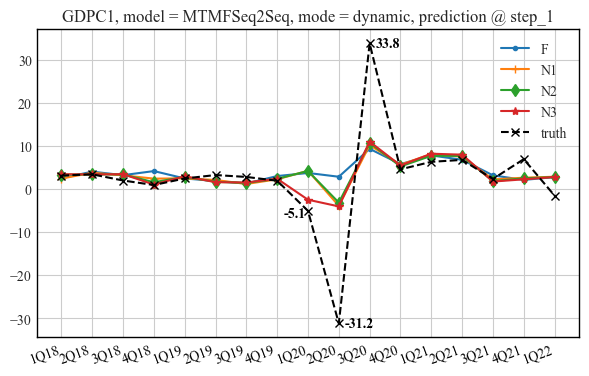

In [26]:
_ = plot_predictions_rolling(variable_name,  model_name = 'MTMFSeq2Seq', 
        mode_tag = 'dynamic', step_tag = 'step_1', df_pred = y_pred, cal_map = cal_map['y_cal_map'], save = f'gdpc1_MTMFSeq2Seq.png')

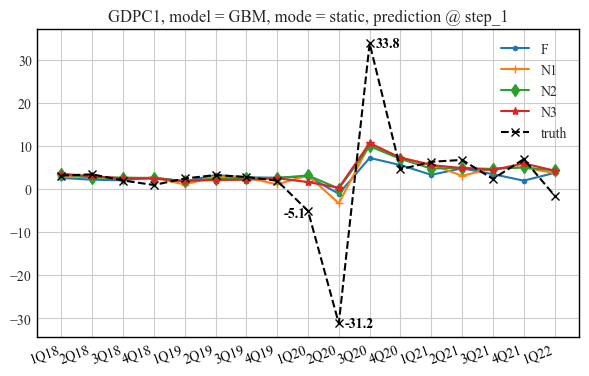

In [27]:
_ = plot_predictions_rolling(variable_name,  model_name = 'GBM', 
        mode_tag = 'static', step_tag = 'step_1', df_pred = y_pred, cal_map = cal_map['y_cal_map'], save = f'gdpc1_GBM.png')